In [93]:
library(data.table)
library(dplyr)
library(tidyr)
library(ggplot2)
library(lubridate)
library(gridExtra)
library(zoo)
library(stringr)
library(rpart)
library(rpart.plot)

In [130]:
events = fread('events-export.csv')

In [131]:
events %>% head()

ts,entity_id,measurement
<chr>,<chr>,<dbl>
2020-10-08 19:00:00,sensor.pressione,1005.45
2020-10-08 19:00:00,sensor.temperatura,22.65
2020-10-08 19:00:00,sensor.umidita,57.50
2020-10-08 18:00:00,sensor.pressione,1005.12
2020-10-08 18:00:00,sensor.temperatura,22.79
2020-10-08 18:00:00,sensor.umidita,58.26


In [132]:
 events <- events %>%
    pivot_wider(names_from = entity_id, values_from = measurement, values_fill = NA) %>%
    mutate(ts = ymd_hms(ts)) %>%
    rename(
        pressione = sensor.pressione, 
        temperatura = sensor.temperatura,
        umidita = sensor.umidita
    ) 
events$pressione[is.na(events$pressione)]     = median(events$pressione, na.rm = T)
events$temperatura[is.na(events$temperatura)] = median(events$temperatura, na.rm = T) 
events$umidita[is.na(events$umidita)]         = median(events$umidita, na.rm = T)

In [134]:
umidita_plot <- ggplot(data = events, aes(x = ts)) + 
    geom_line(aes(y = umidita), color = 'blue')

pressione_plot <- ggplot(data = events, aes(x = ts)) + 
    geom_line(aes(y = pressione), color = 'orange')

temperatura_plot <- ggplot(data = events, aes(x = ts)) + 
    geom_line(aes(y = temperatura), color = 'red')

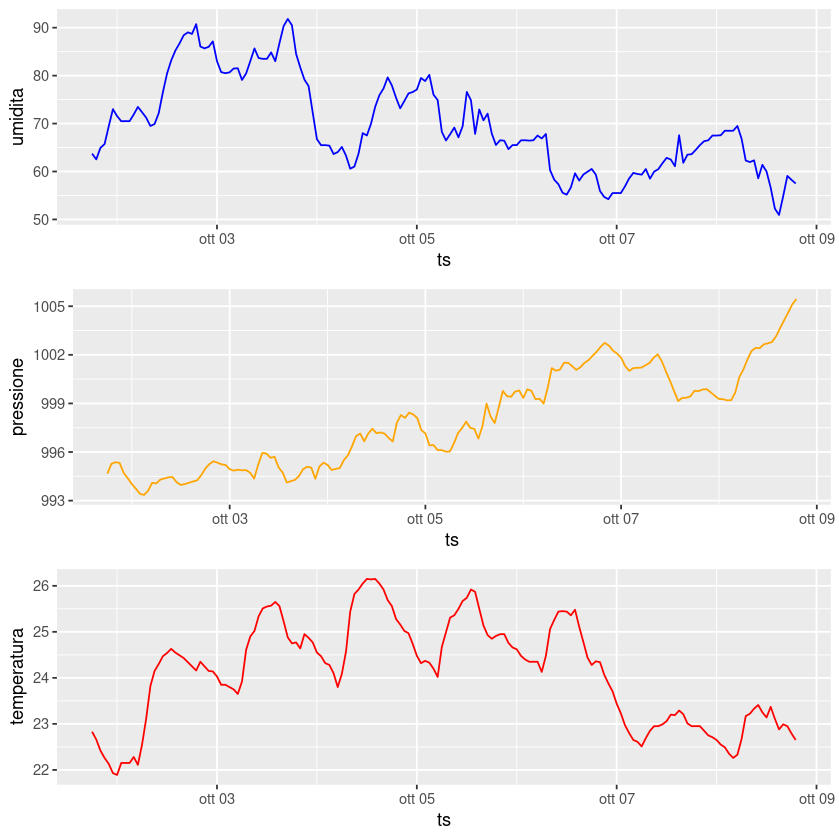

In [135]:
grid.arrange(
    umidita_plot, 
    pressione_plot, 
    temperatura_plot, 
    ncol = 1)

In [137]:
events_fe <- events %>% 
    arrange(desc(ts)) %>%
    mutate(next_temperatura = lag(temperatura, 1)) %>%
    arrange(ts) %>% 
    mutate(
        ma_3_pressione = rollmean(x = pressione, k = 3, align = 'right', fill = NA), 
        ma_6_pressione = rollmean(x = pressione, k = 6, align = 'right', fill = NA),
        ma_12_pressione = rollmean(x = pressione, k = 12, align = 'right', fill = NA), 
        ma_24_pressione = rollmean(x = pressione, k = 24, align = 'right', fill = NA),
       # 
       # ma_3_temperatura = rollmean(x = temperatura, k = 3, align = 'right', fill = NA), 
       # ma_6_temperatura = rollmean(x = temperatura, k = 6, align = 'right', fill = NA),
       # ma_12_temperatura = rollmean(x = temperatura, k = 12, align = 'right', fill = NA), 
       # ma_24_temperatura = rollmean(x = temperatura, k = 24, align = 'right', fill = NA),

        ma_3_umidita = rollmean(x = umidita, k = 3, align = 'right', fill = NA), 
        ma_6_umidita = rollmean(x = umidita, k = 6, align = 'right', fill = NA),
        ma_12_umidita = rollmean(x = umidita, k = 12, align = 'right', fill = NA), 
        ma_24_umidita = rollmean(x = umidita, k = 24, align = 'right', fill = NA),

        hod = str_pad(hour(ts), 2, 'left', '0')
        
    ) %>% 
    filter(!is.na(ma_24_pressione), !is.na(next_temperatura))

events_fe$hod <- factor(events_fe$hod, levels = events_fe$hod %>% unique %>% sort, ordered = T)

In [143]:
mod <- lm(next_temperatura ~ -1 + ., data = events_fe %>% 
          select(-c(ts, temperatura)))
summary(mod)


Call:
lm(formula = next_temperatura ~ -1 + ., data = events_fe %>% 
    select(-c(ts, temperatura)))

Residuals:
    Min      1Q  Median      3Q     Max 
-1.1940 -0.3702 -0.1102  0.4040  1.1681 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
pressione        7.855e-02  1.965e-01   0.400  0.69014    
umidita         -1.624e-02  3.128e-02  -0.519  0.60468    
ma_3_pressione   1.805e-01  3.790e-01   0.476  0.63480    
ma_6_pressione  -1.048e+00  4.891e-01  -2.142  0.03435 *  
ma_12_pressione  1.283e+00  3.201e-01   4.009  0.00011 ***
ma_24_pressione -8.657e-01  1.292e-01  -6.700 8.73e-10 ***
ma_3_umidita    -6.839e-04  5.721e-02  -0.012  0.99048    
ma_6_umidita     3.416e-02  5.581e-02   0.612  0.54178    
ma_12_umidita   -1.160e-01  3.805e-02  -3.048  0.00287 ** 
ma_24_umidita    7.400e-02  2.740e-02   2.701  0.00799 ** 
hod00            3.960e+02  6.820e+01   5.807 6.05e-08 ***
hod01            3.959e+02  6.820e+01   5.805 6.11e-08 ***
hod02            3.957

In [104]:
events_fe$ts %>% range

[1] "2020-10-02 17:00:00 UTC" "2020-10-08 18:00:00 UTC"

[1] 112  12
[1] 34 12


,next_temperatura,,.1,.2,.3,.4,.5,.6,.7,.8,⋯,,.1,.2,.3,.4,.5,.6,.7,.8,.9
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
2,23,when,ma_24_umidita,<,62,,,,,,⋯,,,,,,,,,,
12,24,when,ma_24_umidita,>=,62,&,hod,is,00 or 01 or 02 or 03 or 04 or 05,,⋯,,,&,ma_6_umidita,>=,78,,,,
28,24,when,ma_24_umidita,>=,62,&,hod,is,16 or 17 or 18 or 19 or 20 or 21 or 22 or 23,&,⋯,,,,,,,,,,
13,24,when,ma_24_umidita,>=,62,&,hod,is,00 or 01 or 02 or 03 or 04 or 05,,⋯,,,&,ma_6_umidita,<,78,,,,
58,24,when,ma_24_umidita,>=,62,&,hod,is,16 or 17 or 18 or 19 or 20 or 21 or 22 or 23,&,⋯,,,,,,,&,ma_3_umidita,<,66
30,25,when,ma_24_umidita,>=,62,&,hod,is,00 or 01 or 02 or 03 or 04 or 05 or 06 or 07,,⋯,,,,,,,,,,
59,25,when,ma_24_umidita,>=,62,&,hod,is,16 or 17 or 18 or 19 or 20 or 21 or 22 or 23,&,⋯,,,,,,,&,ma_3_umidita,>=,66
62,25,when,ma_24_umidita,>=,62,&,hod,is,08 or 09 or 10 or 11 or 12 or 13 or 14 or 15 or 16 or 17 or 18 or 19 or 20 or 21 or 22 or 23,&,⋯,,,,,,,,,,
126,25,when,ma_24_umidita,>=,62,&,hod,is,08 or 09 or 10 or 11 or 12 or 13 or 14 or 15 or 16 or 17 or 18 or 19 or 20 or 21 or 22 or 23,&,⋯,>=,73,,,,,,,,


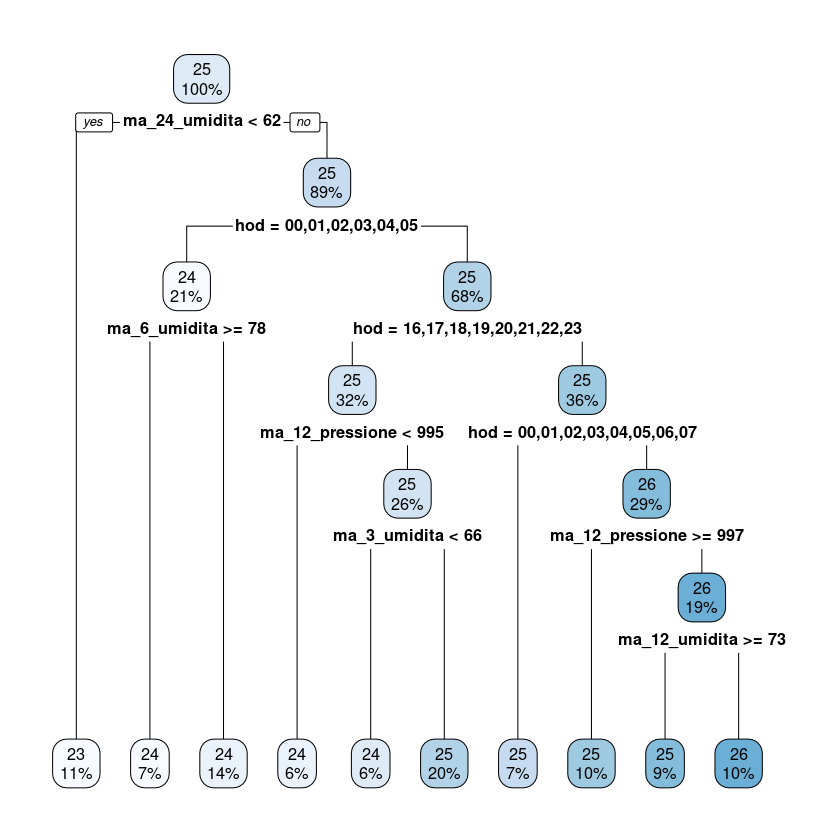

In [144]:
train_data <- events_fe %>% 
    filter(ts <= "2020-10-07 10:00:00") %>%
    select(-c(ts, temperatura)) %>% 
    data.frame()

print(train_data %>% dim())

test_data <- events_fe %>% 
    filter(ts > "2020-10-07 10:00:00") %>%
    select(-c(ts, temperatura)) %>% 
    data.frame()

print(test_data %>% dim())

tree <- rpart(next_temperatura ~ ., data = train_data)
rpart.rules(tree)
rpart.plot(tree)

In [ ]:
for(i in 1:nrow(train_data)){
    
}